# 移動平均を用いた軌跡のギザギザの解消

In [5]:
# 必要なライブラリをインポート
import math
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import Point
import os

import matplotlib.pyplot as plt
from xyzservices import TileProvider
import contextily as cx

import movingpandas as mpd
from sklearn.neighbors import BallTree
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [6]:
# ディレクトリの指定
os.chdir("/mnt/f/grad_thesis/tracking/st_nn11")

In [7]:
def compute_step_speed(
    tdf: gpd.GeoDataFrame,
    id_col: str = "ObjectID",
    time_col: str = "datetime",
    x_col: str = "x",
    y_col: str = "y",
    drop_intermediate: bool = True,
    with_components: bool = True,
) -> gpd.GeoDataFrame:
    """
    同一ID内の連続点から1ステップ距離と速度を計算し、sdf（新しいGeoDataFrame）を返す。

    前提:
        - tdf は EPSG:6677（メートル）想定
        - 列: id_col, time_col, x_col, y_col, geometry を持つことを推奨

    追加される列:
        - step_m    : 1ステップ（前点→現点）の移動距離 [m]
        - speed_mps : 1ステップの速度 [m/s]
        - speed_kmh : 1ステップの速度 [km/h]
        - vx_mps, vy_mps : 速度ベクトル成分 [m/s]（with_components=True のとき）

    注意:
        - 同一ID内で time_col で昇順ソートした上で、直前との差分で計算します。
        - 最初の点や dt<=0 のケースは NaN になります。
    """
    sdf = tdf.sort_values([id_col, time_col]).copy()

    # ひとつ前の点・時刻
    sdf["_x_prev"] = sdf.groupby(id_col)[x_col].shift(1)
    sdf["_y_prev"] = sdf.groupby(id_col)[y_col].shift(1)
    sdf["_t_prev"] = sdf.groupby(id_col)[time_col].shift(1)

    # 差分（距離[m]・経過時間[s]）
    sdf["_dx"]   = sdf[x_col] - sdf["_x_prev"]
    sdf["_dy"]   = sdf[y_col] - sdf["_y_prev"]
    sdf["_dt_s"] = (sdf[time_col] - sdf["_t_prev"]).dt.total_seconds()

    # 不正な dt（0以下）は無効化
    sdf.loc[sdf["_dt_s"] <= 0, ["_dx", "_dy", "_dt_s"]] = np.nan

    # 1ステップ移動距離[m]と速度
    sdf["step_m"]    = np.hypot(sdf["_dx"], sdf["_dy"])
    sdf["speed_mps"] = sdf["step_m"] / sdf["_dt_s"]          # m/s
    sdf["speed_kmh"] = sdf["speed_mps"] * 3.6                 # km/h

    if with_components:
        sdf["vx_mps"] = sdf["_dx"] / sdf["_dt_s"]
        sdf["vy_mps"] = sdf["_dy"] / sdf["_dt_s"]

    # 中間列の片付け
    if drop_intermediate:
        cols_to_drop = ["_x_prev", "_y_prev", "_t_prev", "_dx", "_dy"]
        if "_dt_s" in sdf.columns:
            cols_to_drop.append("_dt_s")
        sdf.drop(columns=cols_to_drop, inplace=True, errors="ignore")

    return sdf

def plot_speed_histogram(
    sdf: gpd.GeoDataFrame,
    speed_col: str = "speed_kmh",
    bin_width: float = 0.5,
    max_kmh: float | None = None,   # None → データから動的決定
    figsize: tuple = (10, 4),
    save_path: str | None = None,
    show: bool = True,
):
    """
    速度（km/h）のヒストグラムを描く。

    - Y axis: 度数（件数）
    - X axis: 時速（km/h）
    - Bin width: 既定 0.5 km/h
    - Max value: 既定はデータから動的に算出（bin 境界に切り上げ）
    """
    # Data extraction (drop NaN/negative)
    spd = sdf[speed_col].to_numpy()
    spd = spd[np.isfinite(spd)]
    spd = spd[spd >= 0]

    if spd.size == 0:
        print("No valid speed data.")
        return None, None

    # Dynamic upper bound aligned to bin edges
    max_obs = float(spd.max())
    if max_kmh is None:
        max_kmh = bin_width * math.ceil(max_obs / bin_width)

    # Bin edges: 0 .. max_kmh with bin_width
    bins = np.arange(0, max_kmh + bin_width, bin_width)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.hist(spd, bins=bins)
    ax.set_xlabel("Speed (km/h)")
    ax.set_ylabel("Count")
    ax.set_xlim(0, max_kmh)
    ax.set_title(f"Speed Histogram (bin width {bin_width} km/h)")

    # Styling
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax


def _google_tile_provider(style: str = "satellite") -> TileProvider:
    """
    Google のタイル定義を返すヘルパー。
    style: "satellite" | "roadmap" | "hybrid" | "terrain"
    """
    style_map = {
        "satellite": "s",
        "roadmap":   "m",
        "hybrid":    "y",
        "terrain":   "p",
    }
    lyrs = style_map.get(style, "s")
    return TileProvider(
        url=f"https://mt1.google.com/vt/lyrs={lyrs}&x={{x}}&y={{y}}&z={{z}}",
        name=f"Google {style}",
        attribution="© Google",
        max_zoom=20,
        ext="png",
    )

def plot_speed_points_on_basemap(
    df: gpd.GeoDataFrame,
    x_col: str = "x",
    y_col: str = "y",
    speed_col: str = "speed_kmh",
    input_crs: str = "EPSG:6677",
    tiles: str = "satellite",      # "satellite"|"roadmap"|"hybrid"|"terrain"
    figsize=(10, 10),
    markersize: float = 2.0,
    alpha: float = 0.9,
    cmap: str = "turbo",           # 速度用の連続カラーマップ
    vmin: float | None = None,
    vmax: float | None = None,
    clip_high_quantile: float = 0.99,  # 外れ値対策（上位1%を上限に）
    save_path: str | None = None,
    show: bool = True,
):
    """
    速度が計算済みの点群を Web メルカトルで可視化し、Google マップを背景に重ねる。

    Parameters
    ----------
    df : GeoDataFrame
        EPSG:6677（メートル）想定。x_col/y_col の数値座標と speed_col（km/h）を持つ。
        geometry が未設定でも可（内部で生成）。
    x_col, y_col : str
        メートル座標（EPSG:6677）の列名。
    speed_col : str
        速度（km/h）の列名。NaN は自動的に除外されず、そのまま描画対象になります。
        （気になる場合は事前に df = df.dropna(subset=[speed_col]) などで処理）
    input_crs : str
        入力の座標参照系。既定は EPSG:6677。
    tiles : str
        背景タイルの種類。"satellite" / "roadmap" / "hybrid" / "terrain"
    figsize : tuple
        図のサイズ（インチ）。
    markersize : float
        散布図のマーカーサイズ。
    alpha : float
        マーカーの不透明度。
    cmap : str
        カラーマップ名（例："turbo", "viridis", "plasma", "rainbow" など）。
    vmin, vmax : float or None
        カラースケールの下限・上限。None の場合はデータ範囲から決定。
    clip_high_quantile : float
        vmax が None のとき、速度の上位何パーセントをクリップ上限にするか（外れ値対策）。
        例：0.99 → 99パーセンタイルを vmax に採用。
    save_path : str or None
        画像保存するパス（例："./outputs/speed_map.png"）。None なら保存しない。
    show : bool
        True なら plt.show() を呼ぶ。

    Returns
    -------
    fig, ax : matplotlib Figure, Axes
    """
    # --- 入力を GeoDataFrame（geometry=Point）に正規化 ---
    if "geometry" not in df.columns or df.geometry.is_empty.any():
        gdf_metric = gpd.GeoDataFrame(
            df.copy(),
            geometry=gpd.points_from_xy(df[x_col], df[y_col]),
            crs=input_crs,
        )
    else:
        gdf_metric = df.copy()
        if gdf_metric.crs is None:
            gdf_metric.set_crs(input_crs, inplace=True)

    # --- Web メルカトルへ変換 ---
    gdf_3857 = gdf_metric.to_crs(epsg=3857)

    # --- カラースケール範囲（外れ値対策を含む） ---
    spd = gdf_3857[speed_col].to_numpy()
    if vmin is None:
        vmin = np.nanmin(spd)
    if vmax is None:
        # 外れ値で色が潰れないよう上位パーセンタイルを採用
        vmax = np.nanpercentile(spd, clip_high_quantile * 100.0)

    # --- 描画 ---
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # GeoPandas の連続値カラーバーを有効化
    gdf_3857.plot(
        ax=ax,
        column=speed_col,
        cmap=cmap,
        markersize=markersize,
        alpha=alpha,
        legend=True,
        legend_kwds={"label": "Speed (km/h)"},
        vmin=vmin,
        vmax=vmax,
    )

    # --- 背景（Google タイル） ---
    provider = _google_tile_provider(tiles)
    cx.add_basemap(ax, source=provider, crs=gdf_3857.crs)

    ax.set_axis_off()
    ax.set_title("Point speed (km/h) on Google Maps", pad=8)

    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")

    if show:
        plt.show()

    return fig, ax

def hampel_filter_series(s: pd.Series, window_size: int = 13, n_sigmas: float = 3.0) -> pd.Series:
    """1次元系列 s に Hampel フィルタを適用し、外れ値を移動中央値で置換して返す。"""
    if window_size % 2 == 0:  # 奇数推奨
        window_size += 1
    med = s.rolling(window=window_size, center=True, min_periods=1).median()
    diff = (s - med).abs()
    mad  = diff.rolling(window=window_size, center=True, min_periods=1).median()
    sigma = 1.4826 * mad
    threshold = n_sigmas * sigma
    mask = (sigma > 0) & (diff > threshold)
    s_filt = s.copy()
    s_filt[mask] = med[mask]
    return s_filt


def apply_hampel_filter_gdf(
    gdf: gpd.GeoDataFrame,
    *,
    id_col: str = "ObjectID",
    time_col: str = "datetime",
    x_col: str = "x",
    y_col: str = "y",
    window_size: int = 13,
    n_sigmas: float = 3.0,
    keep_original: bool = True,
    sort_before: bool = True,
    verbose: bool = True,
):
    """
    GeoDataFrame の x_col / y_col に Hampel フィルタを ID ごとの時系列順で適用。
    - 入力 gdf は変更せず、新しい GeoDataFrame（Hgdf）を返す。
    - 置換回数と置換率（total/N*100）を算出・表示（verbose=True）。
    - 置換が発生した行を 0/1 の列 `hampel_replaced` として付与（keep_original=True のとき）。

    Returns
    -------
    Hgdf : GeoDataFrame
        フィルタ適用後のデータ。`hampel_replaced`（0/1）列を含む（keep_original=True のとき）。
    stats : dict
        {
          'N': int,
          'replaced_x': int, 'replaced_y': int, 'replaced_total': int,
          'replaced_rate': float  # 0〜1
        }
    """
    required = {id_col, time_col, x_col, y_col}
    missing = [c for c in required if c not in gdf.columns]
    if missing:
        raise ValueError(f"必要な列が不足しています: {missing}")

    Hgdf = gdf.copy()
    if sort_before:
        Hgdf = Hgdf.sort_values([id_col, time_col])

    # 元値を退避（置換フラグ・回数算出に使用）
    if keep_original:
        Hgdf[f"{x_col}_orig"] = Hgdf[x_col]
        Hgdf[f"{y_col}_orig"] = Hgdf[y_col]

    # Hampel フィルタ適用（IDごと）
    Hgdf[x_col] = (
        Hgdf.groupby(id_col, group_keys=False)[x_col]
            .apply(lambda s: hampel_filter_series(s, window_size=window_size, n_sigmas=n_sigmas))
    )
    Hgdf[y_col] = (
        Hgdf.groupby(id_col, group_keys=False)[y_col]
            .apply(lambda s: hampel_filter_series(s, window_size=window_size, n_sigmas=n_sigmas))
    )

    # —— 置換回数・置換フラグの算出 —— #
    N = len(Hgdf)

    def _changed_series(new: pd.Series, old: pd.Series) -> pd.Series:
        both_nan = new.isna() & old.isna()
        close = np.isclose(new.astype(float), old.astype(float), equal_nan=False, rtol=0, atol=1e-12)
        return ~(both_nan | close)

    if keep_original:
        changed_x = _changed_series(Hgdf[x_col], Hgdf[f"{x_col}_orig"])
        changed_y = _changed_series(Hgdf[y_col], Hgdf[f"{y_col}_orig"])
        replaced_x = int(changed_x.sum())
        replaced_y = int(changed_y.sum())
        replaced_total = replaced_x + replaced_y
        # 行単位の置換フラグ（x または y のどちらかが置換されていれば 1）
        Hgdf["hampel_replaced"] = (changed_x | changed_y).astype(int)
    else:
        # 元値が無いと厳密な比較ができないため、統計は 0 扱い・フラグは欠損に
        replaced_x = replaced_y = replaced_total = 0
        Hgdf["hampel_replaced"] = pd.NA

    replaced_rate = (replaced_total / N) if N > 0 else 0.0

    stats = {
        "N": N,
        "replaced_x": replaced_x,
        "replaced_y": replaced_y,
        "replaced_total": replaced_total,
        "replaced_rate": replaced_rate,  # 0〜1
    }

    if verbose:
        print(
            "Hampel replacements: "
            f"x={replaced_x}, y={replaced_y}, total={replaced_total} / N={N} "
            f"({replaced_rate*100:.2f}%)"
        )

    return Hgdf, stats

def centered_rolling_smooth_and_trim_xy(
    df: gpd.GeoDataFrame,
    *,
    id_col: str = "ObjectID",
    time_col: str = "datetime",
    window_radius: int = 60,
    min_valid: int = 1,            # 欠損は許容（有効データが min_valid 個以上あれば平均）
    sort_before: bool = True,
    update_geometry: bool = False, # True: geometry を平滑後の x,y で更新
) -> gpd.GeoDataFrame:
    """
    x, y 列のみを用いて中心化移動平均を適用し、端を R 点ずつ切り落とした
    GeoDataFrame（分析用）を返す。

    - 入力: df（x, y 列は「既にフィルタ後」であってもそのまま使用）
    - 出力: 端を切り落とした df（x, y は平滑化後に上書きされた状態）

    注意:
      - 欠損は rolling(mean) 側で無視（min_valid 以上の有効点があれば平均）。
      - 個体の系列長 <= 2*R は全て落ちます。
    """
    g = df.copy()
    if sort_before:
        g = g.sort_values([id_col, time_col])

    R = int(window_radius)
    WINDOW_SIZE = 2 * R + 1

    # x, y をそのまま平滑化して上書き
    g["x"] = g.groupby(id_col)["x"].transform(
        lambda s: s.rolling(WINDOW_SIZE, center=True, min_periods=min_valid).mean()
    )
    g["y"] = g.groupby(id_col)["y"].transform(
        lambda s: s.rolling(WINDOW_SIZE, center=True, min_periods=min_valid).mean()
    )

    # 端を R 点ずつ切り落とす
    pos = g.groupby(id_col).cumcount()
    n   = g.groupby(id_col)[id_col].transform("size")
    trimmed = g[(pos >= R) & (pos <= n - 1 - R)].copy()

    if update_geometry:
        trimmed = gpd.GeoDataFrame(
            trimmed,
            geometry=gpd.points_from_xy(trimmed["x"], trimmed["y"]),
            crs=g.crs
        )

    return trimmed


Mpersons.gpkgからgdf（時間カラムを持つ）を作成

In [8]:
# ── パラメータ ───────────────────────────────
GPKG_PATH     = "Mpersons.gpkg"        # 既にアップロード済み
FPS           = 60                     # 1 秒あたりのフレーム数
BASE_TIME     = datetime(2025, 1, 1, tzinfo=ZoneInfo("Asia/Tokyo"))
WINDOW_RADIUS = 60                     # 前後フレーム数（←ここを変えるだけでOK）
WINDOW_SIZE   = WINDOW_RADIUS * 2 + 1  # 実際の rolling 幅（中心点を含める）

# ── GeoPackage を読み込み ─────────────────
gdf = gpd.read_file(GPKG_PATH)  # gdf.crs は EPSG:6677 を想定（単位=メートル）
if gdf.crs is None or gdf.crs.to_epsg() != 6677:
    print(f"警告: gdf.crs = {gdf.crs}（想定: EPSG:6677）。以降はメートル前提で処理します。")

# ── 座標カラムを用意（EPSG:6677 なので x/y はメートル）────────
gdf["x_raw"] = gdf.geometry.x
gdf["y_raw"] = gdf.geometry.y

# ── Frame 番号から日時を生成 ─────────────────────────────
gdf["datetime"] = gdf["Frame"].apply(
    lambda f: BASE_TIME + timedelta(seconds=f / FPS)
)

# ── 時間順に並べ替え（※移動平均の計算は次セル）────────────
gdf = gdf.sort_values(["ObjectID", "datetime"])

gdf.head()  # データの先頭を表示（確認用）

,Frame,ObjectID,x,y,geometry,x_raw,y_raw,datetime
1061,72,4,1155.621094,-1110.866333,POINT (-11904.641 -34432.484),-11904.641270,-34432.484465,2025-01-01 00:00:01.200000+09:00
1078,73,4,1159.660278,-1104.546875,POINT (-11904.634 -34432.442),-11904.634395,-34432.441535,2025-01-01 00:00:01.216667+09:00
1095,74,4,1162.037842,-1098.101196,POINT (-11904.643 -34432.406),-11904.643057,-34432.406142,2025-01-01 00:00:01.233333+09:00
1112,75,4,1163.869141,-1092.910889,POINT (-11904.651 -34432.378),-11904.650780,-34432.378043,2025-01-01 00:00:01.250000+09:00
1129,76,4,1164.256226,-1088.617554,POINT (-11904.667 -34432.36),-11904.667314,-34432.360233,2025-01-01 00:00:01.266667+09:00


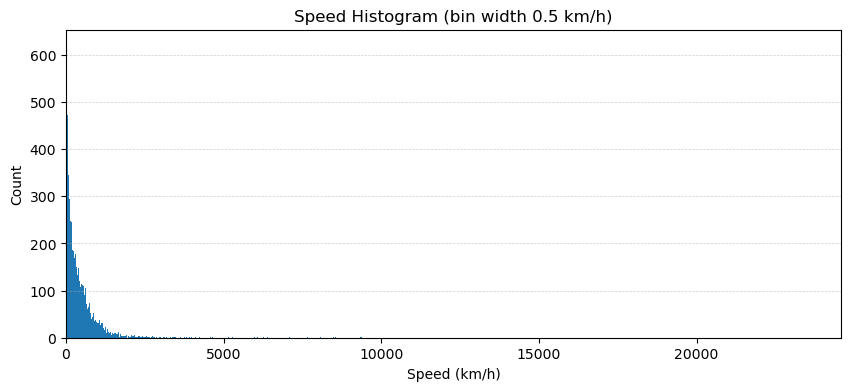

,Frame,ObjectID,x,y,geometry,x_raw,y_raw,datetime,step_m,speed_mps,speed_kmh,vx_mps,vy_mps
1061,72,4,1155.621094,-1110.866333,POINT (-11904.641 -34432.484),-11904.641270,-34432.484465,2025-01-01 00:00:01.200000+09:00,NaN,NaN,NaN,NaN,NaN
1078,73,4,1159.660278,-1104.546875,POINT (-11904.634 -34432.442),-11904.634395,-34432.441535,2025-01-01 00:00:01.216667+09:00,7.500037,449.993246,1619.975686,242.346227,379.159897
1095,74,4,1162.037842,-1098.101196,POINT (-11904.643 -34432.406),-11904.643057,-34432.406142,2025-01-01 00:00:01.233333+09:00,6.870195,412.228201,1484.021525,142.659515,386.756193
1112,75,4,1163.869141,-1092.910889,POINT (-11904.651 -34432.378),-11904.650780,-34432.378043,2025-01-01 00:00:01.250000+09:00,5.503903,330.227577,1188.819278,109.875732,311.412229
1129,76,4,1164.256226,-1088.617554,POINT (-11904.667 -34432.36),-11904.667314,-34432.360233,2025-01-01 00:00:01.266667+09:00,4.310749,258.639787,931.103235,23.224633,257.594946


In [9]:
# 速度を計算
sdf = compute_step_speed(gdf, id_col="ObjectID", time_col="datetime", x_col="x", y_col="y")

plot_speed_histogram(
    sdf,
    speed_col="speed_kmh",
    bin_width=0.5,             # 指定どおり
    max_kmh=None,              # データから自動で上限決定
    save_path="./outputs/speed_hist_0p5.png"
)

sdf.head()  # 計算結果の先頭を表示（確認用）

In [10]:
Hgdf, stats = apply_hampel_filter_gdf(
    gdf,
    id_col="ObjectID",
    time_col="datetime",
    x_col="x",
    y_col="y",
    window_size=13,
    n_sigmas=3.0,
    keep_original=True,   # 置換回数の計測に使うので True 推奨
    sort_before=True,
    verbose=True,         # コンソールに回数を表示
)

Hgdf.head()  # データの先頭を表示（確認用）


Hampel replacements: x=14851, y=23921, total=38772 / N=326728 (11.87%)


,Frame,ObjectID,x,y,geometry,x_raw,y_raw,datetime,x_orig,y_orig,hampel_replaced
1061,72,4,1155.621094,-1110.866333,POINT (-11904.641 -34432.484),-11904.641270,-34432.484465,2025-01-01 00:00:01.200000+09:00,1155.621094,-1110.866333,0
1078,73,4,1159.660278,-1104.546875,POINT (-11904.634 -34432.442),-11904.634395,-34432.441535,2025-01-01 00:00:01.216667+09:00,1159.660278,-1104.546875,0
1095,74,4,1162.037842,-1098.101196,POINT (-11904.643 -34432.406),-11904.643057,-34432.406142,2025-01-01 00:00:01.233333+09:00,1162.037842,-1098.101196,0
1112,75,4,1163.869141,-1092.910889,POINT (-11904.651 -34432.378),-11904.650780,-34432.378043,2025-01-01 00:00:01.250000+09:00,1163.869141,-1092.910889,0
1129,76,4,1164.256226,-1088.617554,POINT (-11904.667 -34432.36),-11904.667314,-34432.360233,2025-01-01 00:00:01.266667+09:00,1164.256226,-1088.617554,0


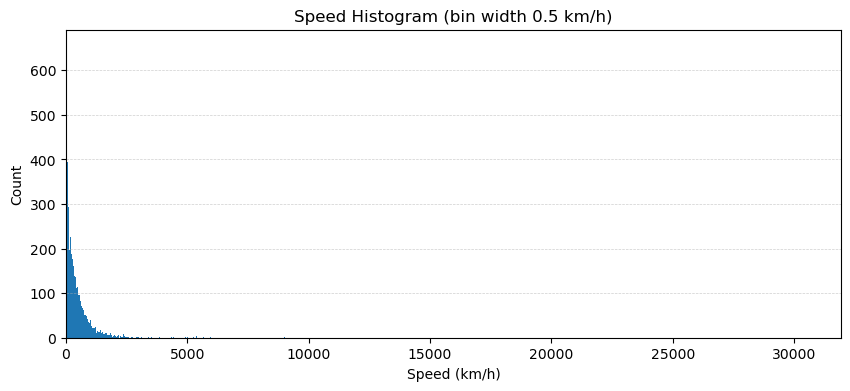

,Frame,ObjectID,x,y,geometry,x_raw,y_raw,datetime,x_orig,y_orig,hampel_replaced,step_m,speed_mps,speed_kmh,vx_mps,vy_mps
1061,72,4,1155.621094,-1110.866333,POINT (-11904.641 -34432.484),-11904.641270,-34432.484465,2025-01-01 00:00:01.200000+09:00,1155.621094,-1110.866333,0,NaN,NaN,NaN,NaN,NaN
1078,73,4,1159.660278,-1104.546875,POINT (-11904.634 -34432.442),-11904.634395,-34432.441535,2025-01-01 00:00:01.216667+09:00,1159.660278,-1104.546875,0,7.500037,449.993246,1619.975686,242.346227,379.159897
1095,74,4,1162.037842,-1098.101196,POINT (-11904.643 -34432.406),-11904.643057,-34432.406142,2025-01-01 00:00:01.233333+09:00,1162.037842,-1098.101196,0,6.870195,412.228201,1484.021525,142.659515,386.756193
1112,75,4,1163.869141,-1092.910889,POINT (-11904.651 -34432.378),-11904.650780,-34432.378043,2025-01-01 00:00:01.250000+09:00,1163.869141,-1092.910889,0,5.503903,330.227577,1188.819278,109.875732,311.412229
1129,76,4,1164.256226,-1088.617554,POINT (-11904.667 -34432.36),-11904.667314,-34432.360233,2025-01-01 00:00:01.266667+09:00,1164.256226,-1088.617554,0,4.310749,258.639787,931.103235,23.224633,257.594946


In [11]:
# 速度を計算
Hsdf = compute_step_speed(
    Hgdf,
    id_col="ObjectID",
    time_col="datetime",
    x_col="x",
    y_col="y"
)

plot_speed_histogram(
    Hsdf,
    speed_col="speed_kmh",
    bin_width=0.5,             # 指定どおり
    max_kmh=None,              # データから自動で上限決定
    save_path="./outputs/speed_hist_0p5_H.png"
)

Hsdf.head()  # 計算結果の先頭を表示（確認用）

In [12]:
# 中心化移動平均で平滑化し、端を切り落とす
M121Hgdf = centered_rolling_smooth_and_trim_xy(
    Hgdf,
    id_col="ObjectID",
    time_col="datetime",
    window_radius=60,
    min_valid=1,
    update_geometry=False
)

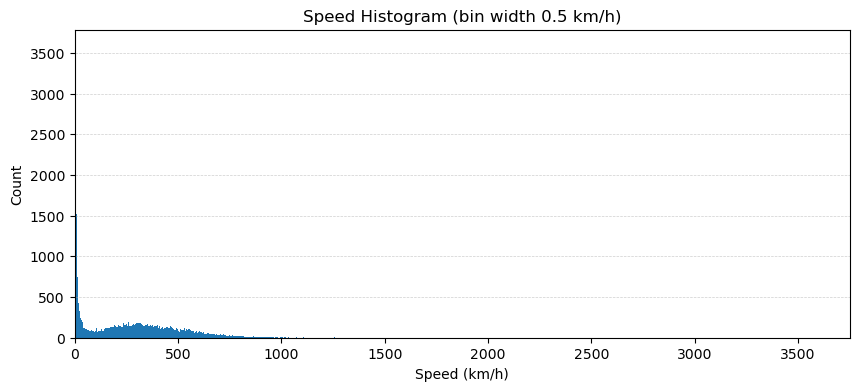

,Frame,ObjectID,x,y,geometry,x_raw,y_raw,datetime,x_orig,y_orig,hampel_replaced,step_m,speed_mps,speed_kmh,vx_mps,vy_mps
857,60,6,1674.335131,-795.516047,POINT (-11901.52 -34428.779),-11901.520459,-34428.779090,2025-01-01 00:00:01+09:00,1669.488525,-795.537354,1,NaN,NaN,NaN,NaN,NaN
874,61,6,1673.055633,-797.234129,POINT (-11901.528 -34428.783),-11901.527810,-34428.782802,2025-01-01 00:00:01.016667+09:00,1668.670166,-795.588928,1,2.142177,128.528060,462.701015,-76.768383,-103.082867
891,62,6,1671.776913,-798.970985,POINT (-11901.531 -34428.783),-11901.531393,-34428.783203,2025-01-01 00:00:01.033333+09:00,1668.377686,-795.436523,0,2.156802,129.413285,465.887825,-76.726258,-104.215544
908,63,6,1670.487610,-800.731299,POINT (-11901.533 -34428.784),-11901.533496,-34428.783712,2025-01-01 00:00:01.050000+09:00,1668.185303,-795.381653,0,2.181973,130.915740,471.296663,-77.356609,-105.616693
925,64,6,1669.199135,-802.488284,POINT (-11901.535 -34428.783),-11901.535191,-34428.783424,2025-01-01 00:00:01.066667+09:00,1668.083008,-795.249329,0,2.178799,130.725349,470.611256,-77.306975,-105.417022


In [13]:
# 速度を計算
M121Hsdf = compute_step_speed(
    M121Hgdf,
    id_col="ObjectID",
    time_col="datetime",
    x_col="x",
    y_col="y"
)

plot_speed_histogram(
    M121Hsdf,
    speed_col="speed_kmh",
    bin_width=0.5,             # 指定どおり
    max_kmh=None,              # データから自動で上限決定
    save_path="./outputs/speed_hist_0p5_H.png"
)

M121Hsdf.head()  # 計算結果の先頭を表示（確認用）

/home/haruichi/.pyenv/versions/miniforge3-22.9.0-2/envs/mesa3_tensorflow/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


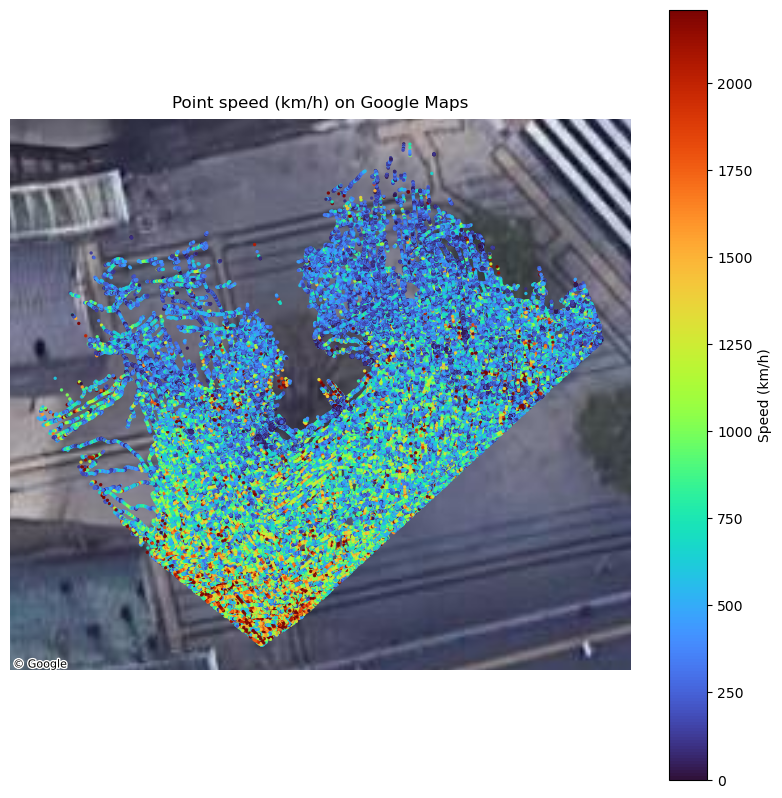

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Point speed (km/h) on Google Maps'}>)

In [15]:
# 速度計算済みの可視化
plot_speed_points_on_basemap(
    Hsdf,
    x_col="x",
    y_col="y",
    speed_col="speed_kmh",
    tiles="satellite",                 # "roadmap" "hybrid" "terrain" も可
    markersize=2.0,
    cmap="turbo",
    save_path="./outputs/speed_satellite2.png",
)


/home/haruichi/.pyenv/versions/miniforge3-22.9.0-2/envs/mesa3_tensorflow/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


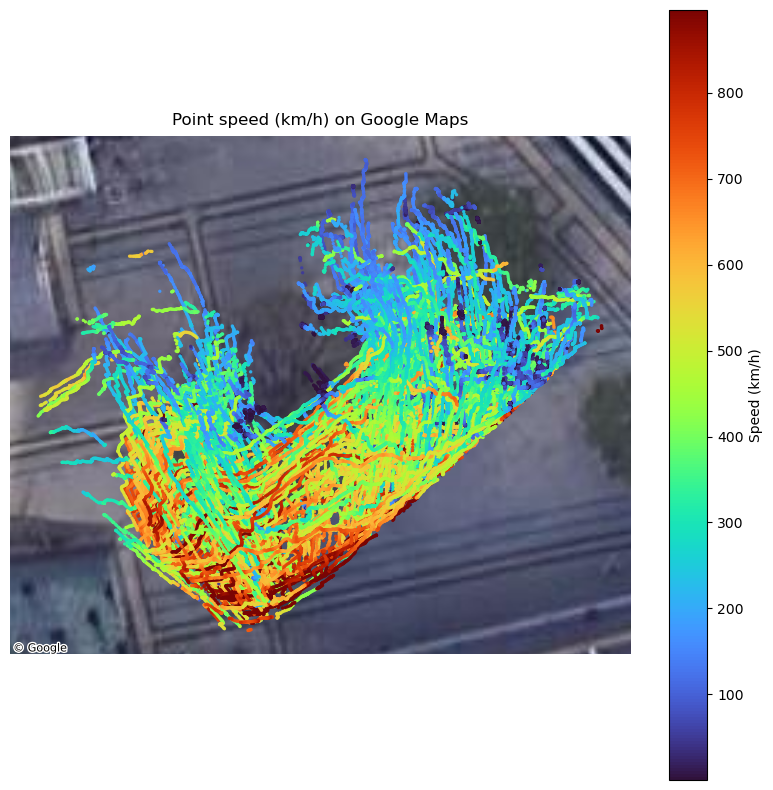

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Point speed (km/h) on Google Maps'}>)

In [14]:
# 速度計算済みの可視化
plot_speed_points_on_basemap(
    M121Hsdf,
    x_col="x",
    y_col="y",
    speed_col="speed_kmh",
    tiles="satellite",                 # "roadmap" "hybrid" "terrain" も可
    markersize=2.0,
    cmap="turbo",
    save_path="./outputs/speed_satellite2.png",
)
